## Watch Your Speed Program (WYSP) - Driver Feedback Sign # 627 in School Safety Zone

## Notebook 1 - Download, prepare and explore the data

### Dataset: "School Safety Zone Watch Your Speed Program – Detailed Speed Counts"

Source: City of Toronto, Open Data https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

The Watch Your Speed Program (WYSP) uses devices called speed display signs or driver feedback signs which contain a radar device and an LED display. These signs are installed on a dedicated wooden pole. The radar measures the speeds of oncoming vehicles and the LED sign displays their speeds to the passing motorists, thereby reminding them to check their speeds and to obey speed limits. The City’s permanent units are installed in Safety Zones. This dataset contains an hourly aggregation of observed speeds for each sign installation in 10km/hr speed range increments. See Location Data for details on where and when signs were installed.

See here for more: https://www.toronto.ca/services-payments/streets-parking-transportation/road-safety/vision-zero/safety-initiatives/safety-zones/

Limitations:
- The count of number of vehicles is not equivalent to a traffic volume count
- Sign addresses have not been verified. They may represent the address of the property adjacent to the sign, which may not be on the same street as the sign
- Speed accuracy is ± 1 km/hr


### Problem

1. Explore the data recorded by the driver feedback sign # 627 (approximate address - 227 Mill Road, Toronto; southbound direction of travel; speed limit - 40 km/hr). The data was collected from January 1, 2019 to February 20, 2020.


2. Train a model to predict hourly count of vehicles with speeds equal to or greater than 40 km/hr in the location where the sign #627 was installed.

Analysis of recorded data and the model can be useful for understanding the situation with safety in this school zone and for planning measures to improve it.

Note: The model cannot be used during the pandemic because the situation in the city has changed (traffic volume has reduced drastically, schools are closed, etc.)

In [1]:
import os
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150)

### Load the data

**1. Read the file with information about locations of installed signs**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Locations 

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/

This dataset contains the locations and operating parameters for each location where a permanent Watch Your Speed Program sign was installed.
Column descriptions are given on the web page ("Data Features" section)

In [3]:
# Read the file with sign locations info

locations = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4e2221b9-da3a-4ef8-b8eb-17e95b7abaa0?format=csv&projection=4326',
                        header=0)
locations.head()

,_id,address,dir,end_date,flash_speed,geometry,min_speed,schedule,sign_id,sign_name,speed_limit,start_date,strobe_speed,ward_no
0,1444,850 Humberwood Boulevard,NB,2018-12-03T15:00:00,41,"{u'type': u'Point', u'coordinates': (-79.6200688334, 43.7289179122)}",30,Weekdays from 7 AM - 9 PM,286,Humberwood Blvd NB,40,2016-11-30T11:00:00,46.0,1.0
1,1445,2612 Kipling Avenue,NB,2020-01-07T23:00:00,61,"{u'type': u'Point', u'coordinates': (-79.584854, 43.748778)}",30,Weekdays from 7 AM - 9 PM,525,Kipling Avve NB,60,2019-08-01T00:00:00,66.0,1.0
2,1446,227 Mill Road,SB,2020-02-20T23:00:00,41,"{u'type': u'Point', u'coordinates': (-79.577376, 43.634306)}",30,Weekdays from 7 AM - 9 PM,627,Mill Rd SB,40,2019-01-01T00:00:00,46.0,2.0
3,1447,92 Jane Street,SB,2019-08-02T03:00:00,61,"{u'type': u'Point', u'coordinates': (-79.485482, 43.65153)}",30,Weekdays from 7 AM - 9 PM,144,Jane St SB,60,2018-01-22T11:00:00,66.0,4.0
4,1448,30 Marmaduke Street,WB,2018-07-03T08:00:00,31,"{u'type': u'Point', u'coordinates': (-79.4512990085, 43.6504567511)}",20,Weekdays from 7 AM - 9 PM,362,Marmaduke St WB,30,2018-02-02T15:00:00,36.0,4.0


In [4]:
len(locations['sign_id'].unique())

# There are 526 signs

526

In [5]:
# Information about the sign #627:

# Data was collected from 2019-01-01 00:00 to 2020-02-20 23:00
# Speed limit = 40 km/hr
# 'schedule': Times of week when the sign is on. Signs still record speeds when the display is inactive.

location_627 = locations[locations['sign_id'] == 627]
location_627

,_id,address,dir,end_date,flash_speed,geometry,min_speed,schedule,sign_id,sign_name,speed_limit,start_date,strobe_speed,ward_no
2,1446,227 Mill Road,SB,2020-02-20T23:00:00,41,"{u'type': u'Point', u'coordinates': (-79.577376, 43.634306)}",30,Weekdays from 7 AM - 9 PM,627,Mill Rd SB,40,2019-01-01T00:00:00,46.0,2.0


**2. Readme file for the "School Safety Zone Watch Your Speed Program – Detailed Speed Counts" data**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Detailed Speed Counts

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

In [6]:
# Readme file for the "School Safety Zone Watch Your Speed Program – Detailed Speed Counts" data contains column descriptions

readme = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/00ee1211-91df-476e-8c9e-8d4b184f25ac', 
                       header=0)
readme

,DB_column,Description,Note
0,ward_no,Ward number,integer
1,sign_id,Unique id for sign location. To be matched with Sign Locations dataset,integer
2,address,Approximate street address where the sign is located,text
3,dir,Cardinal direction of travel,Text (e.g. NB = North Bound)
4,datetime_bin,Start of the hour during which these observations were made,timestamp
5,speed_bin,"Range of speeds observed (e.g. [10,20) represents speeds from 10km/hr up to and not including 20 km/hr)",integer range
6,volume,Number of vehicles observed in that hour and speed bin,integer


**3. Download the datasets: "School Safety Zone Watch Your Speed Program – Detailed Speed Counts"**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Detailed Speed Counts

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

In [7]:
# Download the datasets (there is a zip file for each year)


# Data for the year 2019
DOWNLOAD_URL_2019 = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/fbbed422-60da-4f83-92f9-5a0faed233c7"
DATA_PATH_2019 = os.path.join("data_wysp", "stationary_count_detailed_2019")
ZIP_NAME_2019 = "stationary_count_detailed_2019.zip"


# Data for the year 2020
DOWNLOAD_URL_2020 = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/bdfac238-e4b6-4b0a-8684-b9c161cbe2aa"
DATA_PATH_2020 = os.path.join("data_wysp", "stationary_count_detailed_2020")
ZIP_NAME_2020 = "stationary_count_detailed_2020.zip"

# Function to fetch the data
def fetch_data(file_url, data_path, zip_name):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, zip_name)
    urllib.request.urlretrieve(file_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip:  
        zip.printdir() # printing all the contents of the zip file
        zip.extractall(path=data_path)
        zip.close()

In [8]:
# Load and extract data for the year 2019

fetch_data(file_url=DOWNLOAD_URL_2019, data_path=DATA_PATH_2019, zip_name=ZIP_NAME_2019)

File Name                                             Modified             Size
wys_stationary_detailed_201901.csv             2020-05-11 16:33:30     47130696
wys_stationary_detailed_201902.csv             2020-05-11 16:33:56     43727974
wys_stationary_detailed_201903.csv             2020-05-11 16:34:36     74644048
wys_stationary_detailed_201904.csv             2020-05-11 16:35:34     99593965
wys_stationary_detailed_201905.csv             2020-05-11 16:36:36    104974736
wys_stationary_detailed_201906.csv             2020-05-11 16:37:32    103175954
wys_stationary_detailed_201907.csv             2020-05-11 16:41:42    107031386
wys_stationary_detailed_201908.csv             2020-05-11 16:45:56    112247803
wys_stationary_detailed_201909.csv             2020-05-11 16:49:52    103801361
wys_stationary_detailed_201910.csv             2020-05-11 16:54:06    112971728
wys_stationary_detailed_201911.csv             2020-05-11 16:58:16    114542208
wys_stationary_detailed_201912.csv      

In [9]:
# Load and the extract data for the year 2020

fetch_data(file_url=DOWNLOAD_URL_2020, data_path=DATA_PATH_2020, zip_name=ZIP_NAME_2020)

File Name                                             Modified             Size
wys_stationary_detailed_202001.csv             2020-05-11 16:16:30    125316952
wys_stationary_detailed_202002.csv             2020-05-11 16:21:16    125198761
wys_stationary_detailed_202003.csv             2020-05-11 16:26:14    142139319
wys_stationary_detailed_202004.csv             2020-05-11 16:30:56    139725621
wys_stationary_detailed_202005.csv             2020-06-16 14:06:06    125843832
wys_stationary_detailed_202006.csv             2020-07-14 13:19:44    119343359
wys_stationary_detailed_202007.csv             2020-08-11 12:40:28    142945521


In [10]:
# Function to read the data into a pandas DataFrame

def load_data(data_path, csv_name):
    csv_path = os.path.join(data_path, csv_name)
    return pd.read_csv(csv_path, header=0)

In [11]:
# Names of csv files

csv_names_2019 = ["wys_stationary_detailed_201901.csv", "wys_stationary_detailed_201902.csv", 
                  "wys_stationary_detailed_201903.csv", "wys_stationary_detailed_201904.csv", 
                  "wys_stationary_detailed_201905.csv", "wys_stationary_detailed_201906.csv", 
                  "wys_stationary_detailed_201907.csv", "wys_stationary_detailed_201908.csv", 
                  "wys_stationary_detailed_201909.csv", "wys_stationary_detailed_201910.csv", 
                  "wys_stationary_detailed_201911.csv", "wys_stationary_detailed_201912.csv"]

csv_names_2020 = ["wys_stationary_detailed_202001.csv", "wys_stationary_detailed_202002.csv",
                  "wys_stationary_detailed_202003.csv", "wys_stationary_detailed_202004.csv",
                  "wys_stationary_detailed_202005.csv", "wys_stationary_detailed_202006.csv",
                  "wys_stationary_detailed_202007.csv"]

In [12]:
# Read csv files with the data for 2019, collect DataFrames in the 'df_list'

df_list = []

for name in csv_names_2019:
    month_2019 = load_data(data_path=DATA_PATH_2019, csv_name=name)
    df_list.append(month_2019)

len(df_list)

12

In [13]:
# Read csv files with the data for 2020, collect DataFrames in the 'df_list_2020'

df_list_2020 = []

for name in csv_names_2020:
    month_2020 = load_data(data_path=DATA_PATH_2020, csv_name=name)
    df_list_2020.append(month_2020)
    
len(df_list_2020)

7

In [14]:
# Append the data for 2020 to the 'df_list'

df_list.extend(df_list_2020)
len(df_list)

19

In [15]:
df_list_2020[0]['sign_id'].value_counts()

665    11644
256    11633
884    11575
899    11461
67     11375
       ...  
147      781
555      341
943      155
609      137
949       59
Name: sign_id, Length: 374, dtype: int64

### Prepare the data (combine, reshape and add new columns)

**Combine all data for sign_id 627 into one DataFrame 'df_full' (from January 2019 to February 2020 - when data was recorded)**

In [16]:
# First, add data for January 2019

df_full = df_list[0][df_list[0].sign_id == 627]
df_full.head()

,sign_id,address,dir,datetime_bin,speed_bin,volume
55585,627,227 Mill Road,SB,2019-01-01T00:00,"[5,10)",1
55586,627,227 Mill Road,SB,2019-01-01T00:00,"[15,20)",2
55587,627,227 Mill Road,SB,2019-01-01T00:00,"[25,30)",3
55588,627,227 Mill Road,SB,2019-01-01T00:00,"[30,35)",2
55589,627,227 Mill Road,SB,2019-01-01T00:00,"[35,40)",3


In [17]:
# Next, add data for months from February 2019 to February 2020 to the 'df_full' DataFrame

for df in df_list[1:]:
    sign_627 = df[df.sign_id == 627]
    df_full = pd.concat([df_full, sign_627], ignore_index=True)
    
df_full.head()

# There are a few rows for each timestamp, they represent hourly counts for different speed bins

,sign_id,address,dir,datetime_bin,speed_bin,volume
0,627,227 Mill Road,SB,2019-01-01T00:00,"[5,10)",1
1,627,227 Mill Road,SB,2019-01-01T00:00,"[15,20)",2
2,627,227 Mill Road,SB,2019-01-01T00:00,"[25,30)",3
3,627,227 Mill Road,SB,2019-01-01T00:00,"[30,35)",2
4,627,227 Mill Road,SB,2019-01-01T00:00,"[35,40)",3


In [18]:
df_full.tail()

,sign_id,address,dir,datetime_bin,speed_bin,volume
96530,627,227 Mill Road,SB,2020-02-20T22:00,"[50,55)",9
96531,627,227 Mill Road,SB,2020-02-20T22:00,"[55,60)",3
96532,627,227 Mill Road,SB,2020-02-20T22:00,"[60,65)",2
96533,627,227 Mill Road,SB,2020-02-20T22:00,"[65,70)",1
96534,627,227 Mill Road,SB,2020-02-20T22:00,"[70,75)",1


In [19]:
df_full.info()

# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96535 entries, 0 to 96534
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sign_id       96535 non-null  int64 
 1   address       96535 non-null  object
 2   dir           96535 non-null  object
 3   datetime_bin  96535 non-null  object
 4   speed_bin     96535 non-null  object
 5   volume        96535 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 4.4+ MB


In [20]:
# Reshape data from "long" to "wide" format. Rows will have all observations for each timestamp.
# Missing values are replaced with zeros (because no vehicles were observed in that speed range during that hour)

pivoted = df_full.pivot(index='datetime_bin', columns='speed_bin', values='volume').fillna(0).astype('int64')
pivoted.head()

speed_bin,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)"
datetime_bin,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0
2019-01-01T02:00,0,0,0,0,0,0,6,4,11,3,8,11,3,3,0,0,0,0,0,0
2019-01-01T03:00,2,0,0,0,2,0,0,6,3,4,10,6,2,0,0,1,0,0,0,0
2019-01-01T04:00,0,0,0,0,1,0,0,1,2,1,3,1,1,0,0,0,0,0,0,0


In [21]:
# Change the name for the DataFrame's columns

pivoted.columns.name = 'variables'
pivoted.head()

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)"
datetime_bin,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0
2019-01-01T02:00,0,0,0,0,0,0,6,4,11,3,8,11,3,3,0,0,0,0,0,0
2019-01-01T03:00,2,0,0,0,2,0,0,6,3,4,10,6,2,0,0,1,0,0,0,0
2019-01-01T04:00,0,0,0,0,1,0,0,1,2,1,3,1,1,0,0,0,0,0,0,0


In [22]:
pivoted.info()

# No missing values. All values are integers.

<class 'pandas.core.frame.DataFrame'>
Index: 9946 entries, 2019-01-01T00:00 to 2020-02-20T22:00
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   [10,15)   9946 non-null   int64
 1   [100,)    9946 non-null   int64
 2   [15,20)   9946 non-null   int64
 3   [20,25)   9946 non-null   int64
 4   [25,30)   9946 non-null   int64
 5   [30,35)   9946 non-null   int64
 6   [35,40)   9946 non-null   int64
 7   [40,45)   9946 non-null   int64
 8   [45,50)   9946 non-null   int64
 9   [5,10)    9946 non-null   int64
 10  [50,55)   9946 non-null   int64
 11  [55,60)   9946 non-null   int64
 12  [60,65)   9946 non-null   int64
 13  [65,70)   9946 non-null   int64
 14  [70,75)   9946 non-null   int64
 15  [75,80)   9946 non-null   int64
 16  [80,85)   9946 non-null   int64
 17  [85,90)   9946 non-null   int64
 18  [90,95)   9946 non-null   int64
 19  [95,100)  9946 non-null   int64
dtypes: int64(20)
memory usage: 1.6+ MB


**Create new columns for analysis and modelling, including a target column - the hourly count of observed vehicles that had speeds of 40 km/hr or higher**

In [23]:
# Add a 'month' column (values from 1 to 12)

pivoted['month'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%m')))
pivoted.head()

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month
datetime_bin,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1
2019-01-01T02:00,0,0,0,0,0,0,6,4,11,3,8,11,3,3,0,0,0,0,0,0,1
2019-01-01T03:00,2,0,0,0,2,0,0,6,3,4,10,6,2,0,0,1,0,0,0,0,1
2019-01-01T04:00,0,0,0,0,1,0,0,1,2,1,3,1,1,0,0,0,0,0,0,0,1


In [24]:
# Add a 'day_of_week' column: values from 0 (Sunday) to 6

pivoted['day_of_week'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%w')))
pivoted.head(2)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week
datetime_bin,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2


In [25]:
# Add an 'hour' column (values from 0 to 23)

pivoted['hour'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%H')))
pivoted.head(2)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2,0
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2,1


In [26]:
# Display schedule for the sign #627 when display is active: Weekdays from 7 AM to 9 PM

# Add a 'display_on' column with values 1 (on) and 0 (off)

pivoted['display_on'] = ((pivoted['day_of_week'] != 0) & (pivoted['day_of_week'] != 6) & 
                        (pivoted['hour'] >= 7) & (pivoted['hour'] < 21)).astype(int)
pivoted.head(2)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2,0,0
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2,1,0


In [27]:
# Add a 'total_count' column: total number of vehicles observed during that hour

pivoted['total_count'] = pivoted.iloc[:, :20].apply(lambda x: x.sum(), axis='columns')
pivoted.head(2)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2,0,0,35
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2,1,0,53


In [28]:
# Add the 'over_40' column (the target): number of vehicles observed at speeds of 40 km/hr or higher during that hour

pivoted['over_40'] = pivoted.iloc[:, [1, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]].apply(lambda x: x.sum(), axis='columns')
pivoted.head(2)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2,0,0,35,24
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2,1,0,53,40


In [29]:
# Add a 'percent_over_40' column: proportion of vehicles at speeds of 40 km/hr or higher during certain hour

pivoted['percent_over_40'] = pivoted['over_40'] / pivoted['total_count']
pivoted.head()

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40,percent_over_40
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01T00:00,0,0,2,0,3,2,3,4,10,1,7,3,0,0,0,0,0,0,0,0,1,2,0,0,35,24,0.685714
2019-01-01T01:00,5,0,1,1,1,0,1,13,5,4,12,6,1,2,0,0,0,1,0,0,1,2,1,0,53,40,0.754717
2019-01-01T02:00,0,0,0,0,0,0,6,4,11,3,8,11,3,3,0,0,0,0,0,0,1,2,2,0,49,40,0.816327
2019-01-01T03:00,2,0,0,0,2,0,0,6,3,4,10,6,2,0,0,1,0,0,0,0,1,2,3,0,36,28,0.777778
2019-01-01T04:00,0,0,0,0,1,0,0,1,2,1,3,1,1,0,0,0,0,0,0,0,1,2,4,0,10,8,0.800000


### Explore the data

In [30]:
# Information about the DataFrame:

# Total number of rows = 9946. Each row represents one timestamp - start of the hour during which the observations were made.
# There are no missing values.
# All columns have numerical values (but the 'month', 'day_of_week', 'hour' and 'display_on' columns are categorical attributes)

pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9946 entries, 2019-01-01T00:00 to 2020-02-20T22:00
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   [10,15)          9946 non-null   int64  
 1   [100,)           9946 non-null   int64  
 2   [15,20)          9946 non-null   int64  
 3   [20,25)          9946 non-null   int64  
 4   [25,30)          9946 non-null   int64  
 5   [30,35)          9946 non-null   int64  
 6   [35,40)          9946 non-null   int64  
 7   [40,45)          9946 non-null   int64  
 8   [45,50)          9946 non-null   int64  
 9   [5,10)           9946 non-null   int64  
 10  [50,55)          9946 non-null   int64  
 11  [55,60)          9946 non-null   int64  
 12  [60,65)          9946 non-null   int64  
 13  [65,70)          9946 non-null   int64  
 14  [70,75)          9946 non-null   int64  
 15  [75,80)          9946 non-null   int64  
 16  [80,85)          9946 non-null   int64

In [31]:
# Summary statistics

pivoted.describe()

# Mean value for the 'over_40' data is about 76, and the median is 73. Min value = 0 and max value = 265.

# Average proportion of vehicles with speeds of 40 km/hr or higher is about 76%, and the median value is about 78%.
# The min value is 0, and max value = 100%.

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40,percent_over_40
count,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000,9946.000000
mean,1.901267,0.005731,0.777800,1.031671,1.732857,3.493766,11.548663,25.259501,24.899859,4.293083,16.095114,6.518500,1.911422,0.561733,0.165192,0.053690,0.020712,0.011663,0.007038,0.003318,5.891514,3.002614,11.500201,0.418460,100.292580,75.513473,0.756501
std,2.336306,0.083098,1.304243,1.688664,2.652360,4.680975,10.910196,20.407102,19.604681,5.959007,13.239003,5.783222,1.991610,0.845929,0.428449,0.240104,0.143830,0.108302,0.083601,0.057509,3.648618,1.996174,6.914449,0.493331,73.603688,56.522598,0.139693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,6.000000,1.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,6.000000,0.000000,27.000000,20.000000,0.709514
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,9.000000,23.000000,23.000000,3.000000,14.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,12.000000,0.000000,100.000000,73.000000,0.777778
75%,3.000000,0.000000,1.000000,1.000000,2.000000,5.000000,18.000000,41.000000,40.000000,6.000000,25.000000,10.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,17.000000,1.000000,158.000000,122.000000,0.833333
max,31.000000,2.000000,26.000000,40.000000,49.000000,61.000000,78.000000,100.000000,105.000000,138.000000,97.000000,43.000000,17.000000,8.000000,4.000000,2.000000,2.000000,2.000000,1.000000,1.000000,12.000000,6.000000,23.000000,1.000000,333.000000,265.000000,1.000000


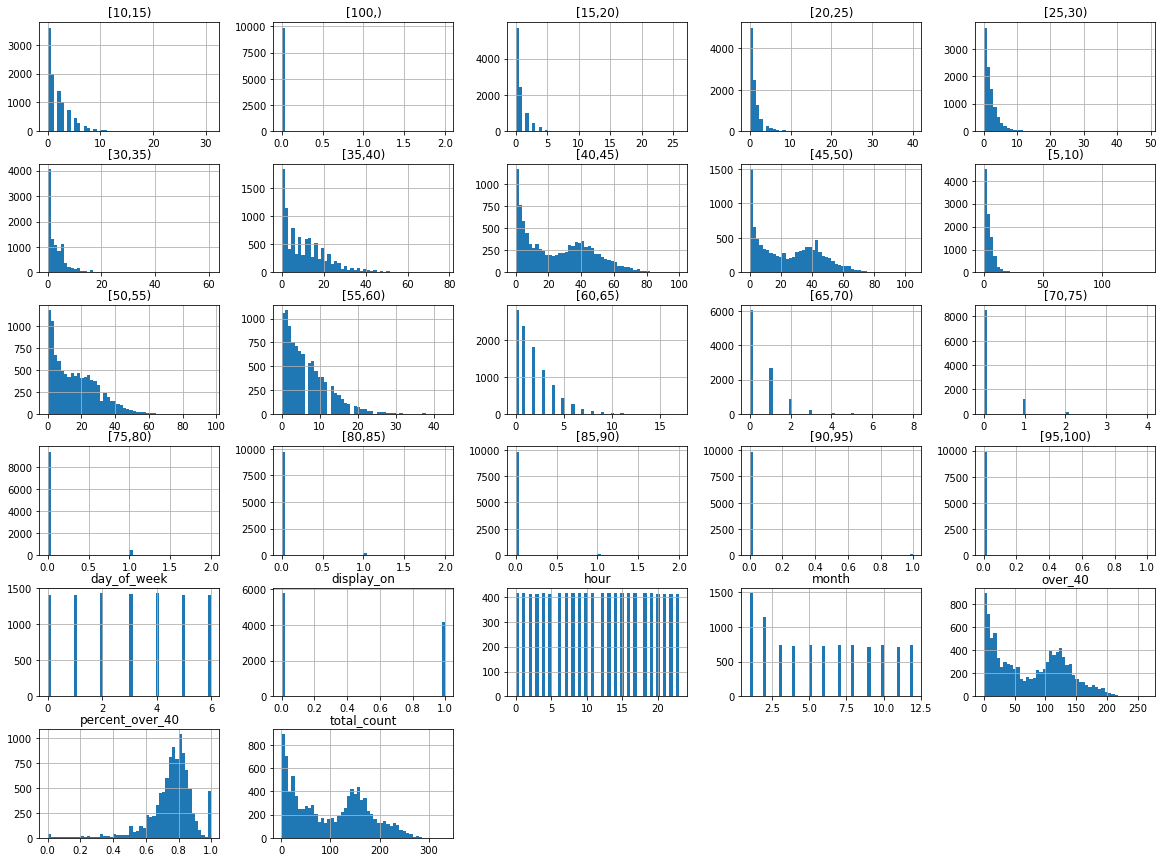

In [32]:
# Plot histograms

pivoted.hist(bins=50, figsize=(20,15))
plt.show()

# For the 'display_on' and 'month' columns: categories have different proportions in the dataset

**Check value counts for categorical attributes:**

In [33]:
# Values for display on and display off are not equally represented

pivoted['display_on'].value_counts()

0    5784
1    4162
Name: display_on, dtype: int64

In [34]:
# The 'display_on' category proportions in the full dataset

pivoted['display_on'].value_counts() / len(pivoted)

0    0.58154
1    0.41846
Name: display_on, dtype: float64

In [35]:
# Value counts for the 'hour' are almost the same

pivoted['hour'].value_counts()

7     416
14    416
6     416
16    416
13    416
12    416
15    416
11    416
18    415
8     415
17    415
10    415
19    414
1     414
9     414
0     414
4     414
20    413
5     413
21    413
22    413
3     412
2     412
23    412
Name: hour, dtype: int64

In [36]:
# Value counts for the 'day_of_week' are quite close

pivoted['day_of_week'].value_counts()

4    1438
2    1432
3    1424
5    1416
6    1415
0    1415
1    1406
Name: day_of_week, dtype: int64

In [37]:
# Data for the sign_id '627' was collected from 2019-01-01 00:00 to 2020-02-20 23:00.
# There are more entries for January and February in the dataset than for other months.

pivoted['month'].value_counts()

1     1488
2     1147
7      744
12     744
3      744
10     744
8      738
5      736
6      720
4      720
11     717
9      704
Name: month, dtype: int64

In [38]:
# The 'month' category proportions in the full dataset

pivoted['month'].value_counts() / len(pivoted)

# Stratified train-test split based on the 'month' category can be done to keep the category proportions for training and testing

1     0.149608
2     0.115323
7     0.074804
12    0.074804
3     0.074804
10    0.074804
8     0.074201
5     0.074000
6     0.072391
4     0.072391
11    0.072089
9     0.070782
Name: month, dtype: float64

In [39]:
# What was the maximum hourly count for the speed bin '100 km/hr and higher'? - 2 vehicles observed during an hour
# Very high speeds were observed at different times of day

sorted_by_100 = pivoted.sort_values(by=['[100,)', '[95,100)'], ascending=False)
sorted_by_100.head(10)

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40,percent_over_40
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-11T23:00,0,2,0,1,0,0,4,10,4,2,2,1,0,0,0,0,0,0,0,0,3,1,23,0,26,19,0.730769
2019-06-20T01:00,0,2,0,0,0,0,0,1,2,0,3,2,0,0,1,0,0,0,0,0,6,4,1,0,11,11,1.000000
2019-06-20T02:00,0,2,0,0,0,0,3,0,4,0,1,1,1,0,0,0,0,0,0,0,6,4,2,0,12,9,0.750000
2019-07-07T10:00,2,2,1,2,1,1,9,29,40,9,20,6,3,1,0,0,0,0,0,0,7,0,10,0,126,101,0.801587
2019-11-30T15:00,5,2,3,2,2,2,16,51,53,3,27,11,5,1,0,0,0,0,0,0,11,6,15,0,183,150,0.819672
2019-12-07T00:00,0,2,1,1,1,2,6,10,13,1,3,6,2,0,1,1,0,0,0,0,12,6,0,0,50,38,0.760000
2019-05-02T21:00,2,1,2,1,1,2,11,20,11,6,14,8,1,0,1,0,0,1,0,1,5,4,21,0,83,58,0.698795
2019-10-10T01:00,0,1,0,0,0,0,0,5,0,0,2,2,0,0,0,0,0,0,0,1,10,4,1,0,11,11,1.000000
2019-01-25T12:00,4,1,0,0,1,3,15,41,42,8,19,9,3,0,0,0,0,0,0,0,1,5,12,1,146,115,0.787671


Text(0, 0.5, 'Number of vehicles')

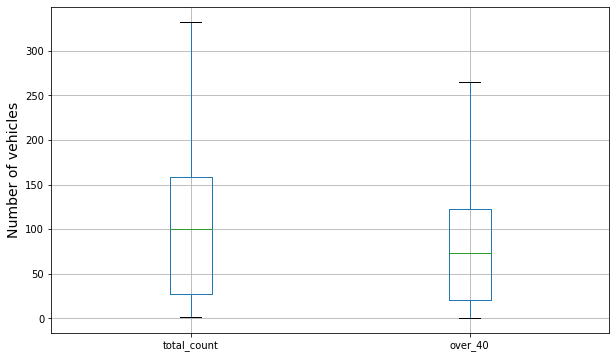

In [40]:
# Box plots for the 'total_count' and 'over_40'

pd.plotting.boxplot(pivoted.iloc[:, -3:-1], figsize=(10,6))
plt.ylabel('Number of vehicles', fontsize=14)

Text(0, 0.5, 'Percentage')

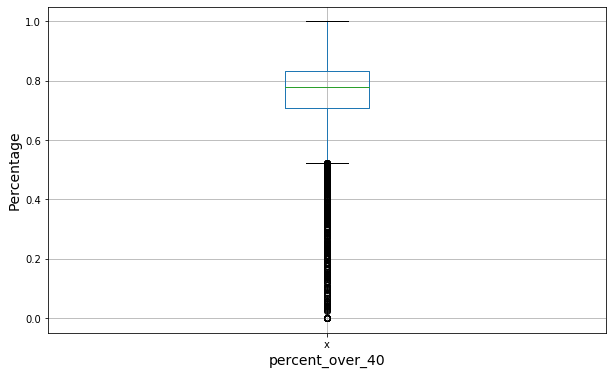

In [41]:
# Box plot for the 'percent_over_40'

pd.plotting.boxplot(pivoted['percent_over_40'], figsize=(10,6))
plt.xlabel('percent_over_40', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

In [42]:
# Group the data by "display_on":
# Average hourly count of vehicles in speed bin 'over_40' is much greater when display is active.
# Average proportion of such vehicles is almost the same when display is inactive (76.6%) and when it is active (74.3%).

grouped_display = pivoted.groupby(pivoted['display_on']).agg(['mean', 'max'])
grouped_display

[10,15)        [100,)       [15,20)       [20,25)       [25,30)  \
                mean max      mean max      mean max      mean max      mean   
display_on                                                                     
0           1.090595  31  0.008126   2  0.420124  26  0.552213  40  0.870505   
1           3.027871  21  0.002403   1  1.274868  18  1.697982  23  2.931283   

                 [30,35)        [35,40)        [40,45)         [45,50)       \
           max      mean max       mean max       mean  max       mean  max   
display_on                                                                    
0           49  1.647303  57   5.264350  52  12.346646   76  13.762621   73   
1           39  6.059827  61  20.282076  78  43.204709  100  40.377463  105   

              [5,10)         [50,55)       [55,60)       [60,65)      \
                mean  max       mean max      mean max      mean max   
display_on                                                             
0           2.681535  138   9.760546  62  4.241528  32  1.377420  14   
1           6.532677   91  24.898366  97  9.682845  43  2.653532  17   

             [65,70)       [70,75)       [75,80)       [80,85)       [85,90)  \
                mean max      mean max      mean max      mean max      mean   
display_on                                                                     
0           0.438451   5  0.143845   4  0.054288   2  0.022649   2  0.014177   
1           0.733061   8  0.194858   4  0.052859   2  0.018020   2  0.008169   

                 [90,95)      [95,100)         month     day_of_week      \
           max      mean max      mean max      mean max        mean max   
display_on                                                                 
0            2  0.010028   1  0.004495   1  5.906812  12    3.002420   6   
1            1  0.002883   1  0.001682   1  5.870255  12    3.002883   5   

                 hour     total_count          over_40      percent_over_40  \
                 mean max        mean  max        mean  max            mean   
display_on                                                                    
0           10.064142  23   54.711445  281   42.184820  191        0.765892   
1           13.495915  20  163.637434  333  121.830851  265        0.743450   

                 
            max  
display_on       
0           1.0  
1           1.0

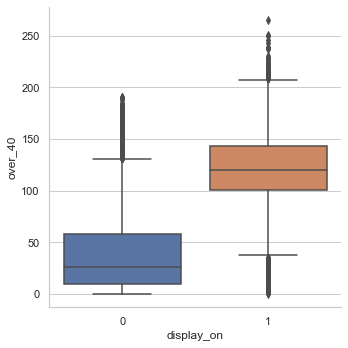

In [43]:
# Box plot of the 'over_40' data by display on/off

sns.set(style="whitegrid")
sns.catplot(x='display_on', y='over_40', kind='box', data=pivoted)

**How the 'over_40', 'total_count' and 'percent_over_40' values changed during a month. Check for December 2019**

Text(0, 0.5, 'over_40')

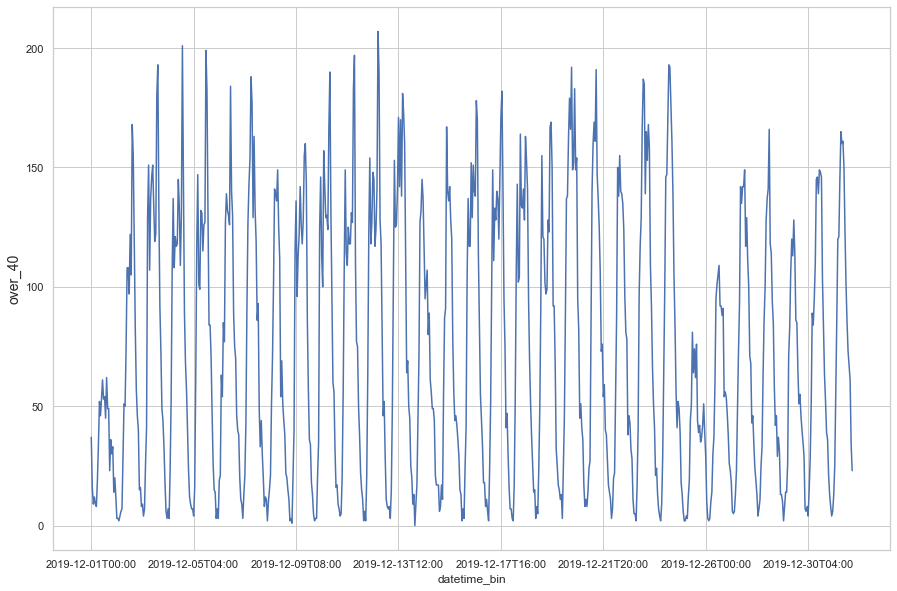

In [44]:
# Plot how the 'over_40' values changed during December 2019

pivoted['over_40'][pivoted.month == 12].plot(figsize=(15,10))
plt.ylabel('over_40', fontsize=14)

In [45]:
# The highest 'over_40' count in December 2019

pivoted['over_40'][pivoted.month == 12].max()

207

In [46]:
# When was it observed? - 2019-12-12, from 4pm to 5pm, Thursday (display active)

pivoted[(pivoted.month == 12) & (pivoted.over_40 == 207)]

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40,percent_over_40
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-12T16:00,5,0,1,1,1,6,37,85,64,4,40,15,3,0,0,0,0,0,0,0,12,4,16,1,262,207,0.790076


Text(0, 0.5, 'total_count')

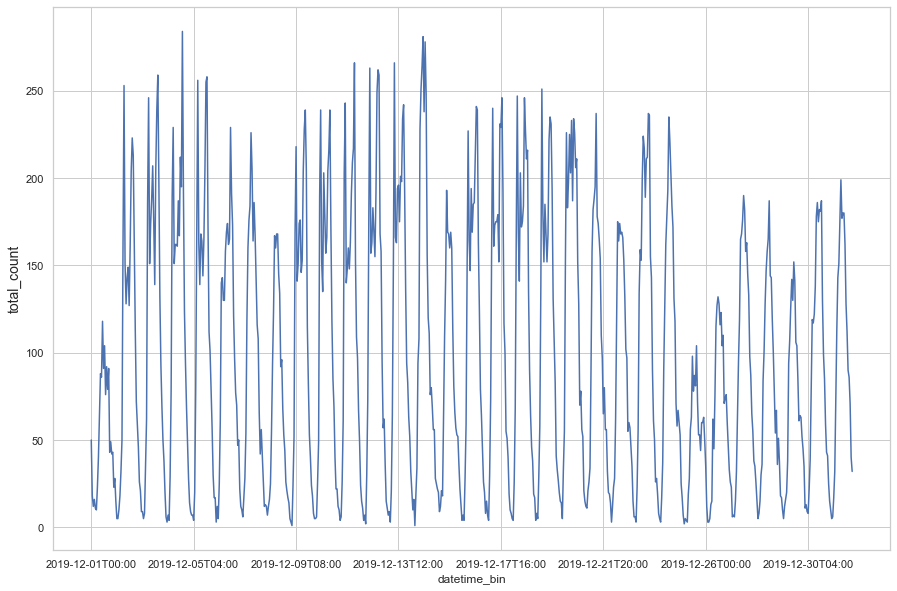

In [47]:
# Plot how the 'total_count' values changed during December 2019

pivoted['total_count'][pivoted.month == 12].plot(figsize=(15,10))
plt.ylabel('total_count', fontsize=14)

Text(0, 0.5, 'percent_over_40')

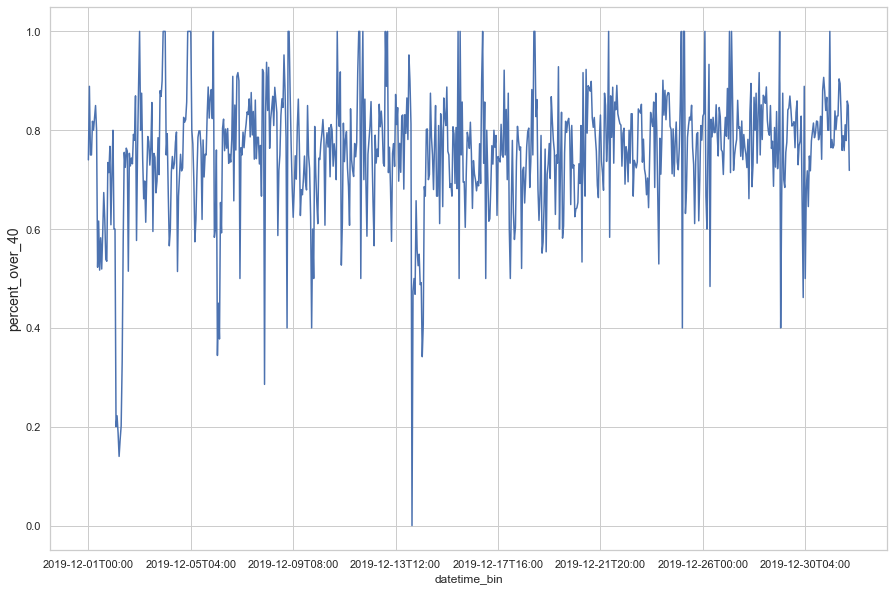

In [48]:
# Plot how the 'percent_over_40' values changed during December 2019

pivoted['percent_over_40'][pivoted.month == 12].plot(figsize=(15,10))
plt.ylabel('percent_over_40', fontsize=14)

In [49]:
# The lowest 'percent_over_40' value in December 2019 - No vehicles were observed in the speed bin "40 km/hr or higher"

pivoted['percent_over_40'][pivoted.month == 12].min()

0.0

In [50]:
# When was it observed? - 2019-12-14, between 4am and 5am, Saturday (display inactive)

pivoted[(pivoted.month == 12) & (pivoted.percent_over_40 == 0.0)]

variables,"[10,15)","[100,)","[15,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[5,10)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)",month,day_of_week,hour,display_on,total_count,over_40,percent_over_40
datetime_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-14T04:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,12,6,4,0,1,0,0.0


**Group the data by hour**

In [51]:
# Group the data by hour (compute group means)

grouped_hour = pivoted[['total_count', 'over_40', 'percent_over_40']].groupby(pivoted['hour']).mean()
grouped_hour

variables,total_count,over_40,percent_over_40
hour,,,
0,23.538647,18.350242,0.785146
1,14.311594,10.842995,0.761624
2,8.410194,6.810680,0.824560
3,6.827670,5.449029,0.823672
4,5.565217,3.797101,0.720208
5,22.123487,15.694915,0.714525
6,48.704327,36.007212,0.740022
7,118.485577,80.750000,0.697108
8,174.718072,115.537349,0.685207


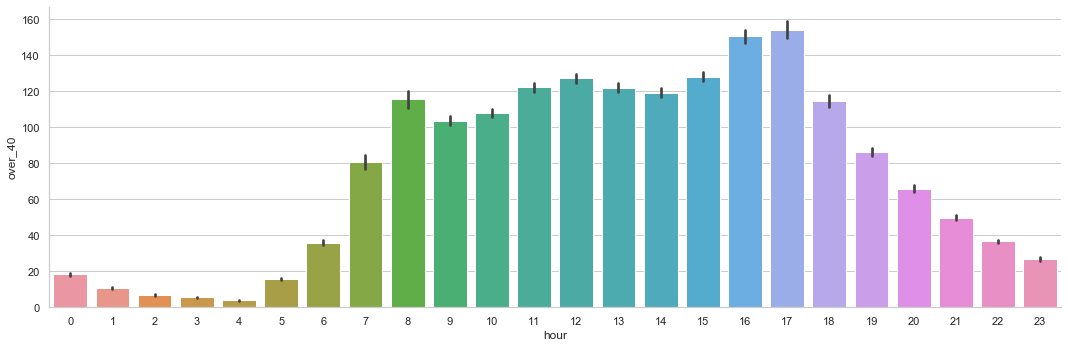

In [52]:
# The 'over_40' data grouped by hour

sns.catplot(x='hour', y='over_40', kind='bar', data=pivoted, aspect=3)

# The mean 'over_40' counts greater than 100 are observed for hours between 8am and 7pm
# The highest values are observed for hours 4pm-5pm and 5pm-6pm

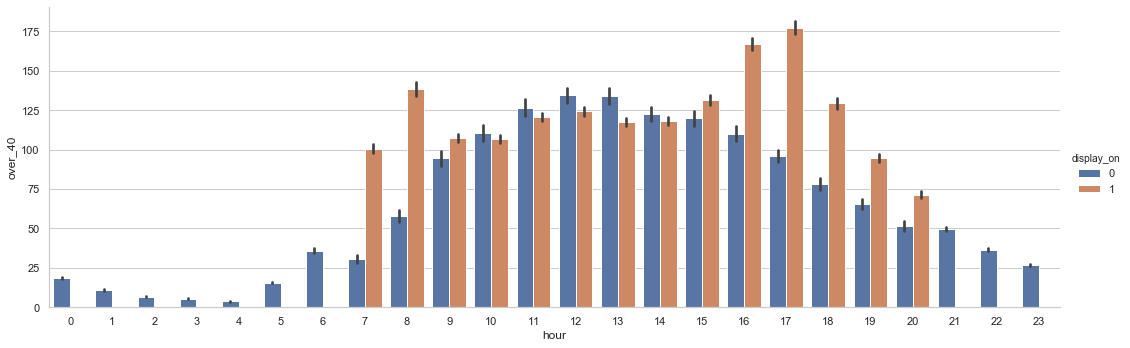

In [53]:
# Average hourly counts of vehicles in speed bin 'over_40' grouped by hour and by display on/off

sns.catplot(x='hour', y='over_40', hue='display_on', kind='bar', data=pivoted, aspect=3)

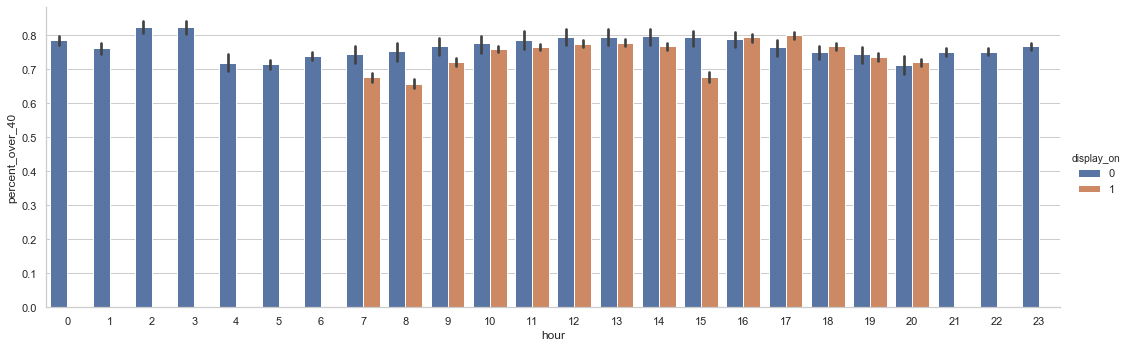

In [54]:
# Average proportion of vehicles in speed bin "40 km/hr or higher" grouped by hour and by display on/off:

# Average proportions of vehicles observed in speed bin "40 km/hr or higher" are greater than 60% for all 'hour' categories.

sns.catplot(x='hour', y='percent_over_40', hue='display_on', kind='bar', data=pivoted, aspect=3)

**Group the data by day of week**

In [55]:
# Group the data by day of week (compute group means):

# After grouping, the highest 'over_40' values are observed for Tuesday, Thursday and Friday (counts from 80 to 87).
# The 'percent_over_40' group means are in the 73-78% range.

grouped_day = pivoted[['total_count', 'over_40', 'percent_over_40']].groupby(pivoted['day_of_week']).mean()
grouped_day

variables,total_count,over_40,percent_over_40
day_of_week,,,
0,73.657244,56.624735,0.749934
1,98.703414,73.266714,0.747272
2,106.837989,79.594274,0.749908
3,108.035112,77.629213,0.733406
4,111.662726,84.162726,0.765057
5,112.518362,86.540960,0.776893
6,90.301767,70.550530,0.773051


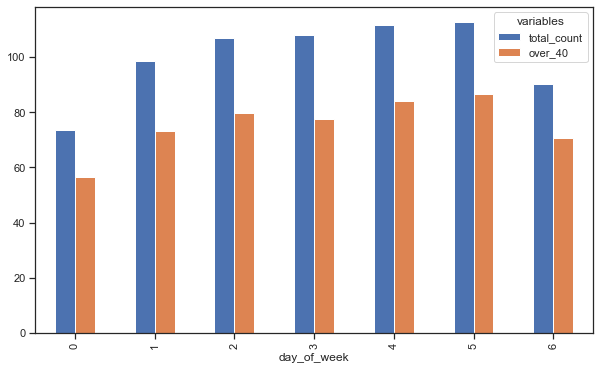

In [56]:
# Average hourly counts of all vehicles and counts of vehicles travelled at speeds of 40 km/hr or higher grouped by day of week

sns.set(style="ticks")
grouped_day[['total_count', 'over_40']].plot.bar(figsize=(10,6))

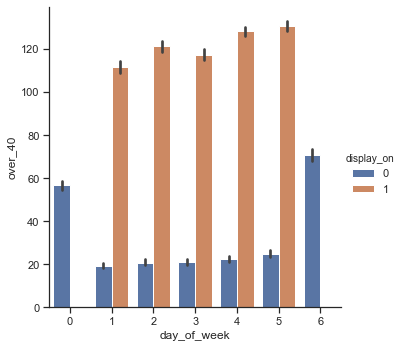

In [57]:
# Average hourly counts of vehicles in speed bin 'over_40' grouped by day of week and by display on/off:

# On weekends display was off
# On weekdays, the average counts were significantly higher when display was on (7am-9pm)

sns.catplot(x='day_of_week', y='over_40', hue='display_on', kind='bar', data=pivoted)

**Group the data by month**

In [58]:
# Group the data by month (compute group means)

grouped_month = pivoted[['total_count', 'over_40', 'percent_over_40']].groupby(pivoted['month']).mean()
grouped_month

variables,total_count,over_40,percent_over_40
month,,,
1,95.122984,69.123656,0.727285
2,94.432432,69.413252,0.739005
3,96.787634,75.727151,0.779767
4,106.631944,83.638889,0.779089
5,111.858696,83.535326,0.757263
6,109.798611,82.754167,0.768761
7,100.793011,80.002688,0.784756
8,90.760163,72.073171,0.751001
9,99.794034,73.085227,0.751415


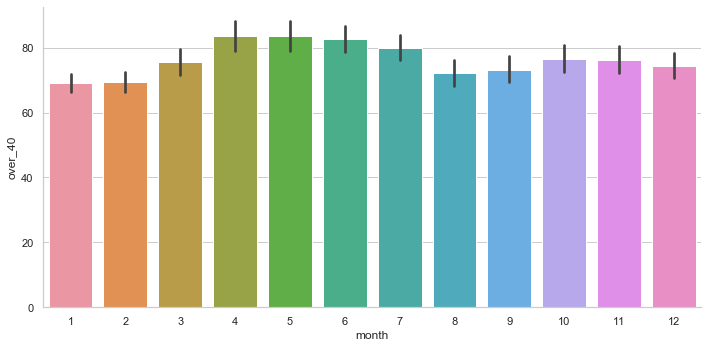

In [59]:
# The 'over_40' data grouped by month:

# The highest values were observed for April, May, June and July

sns.set(style="whitegrid")
sns.catplot(x='month', y='over_40', kind='bar', data=pivoted, aspect=2)

### Split data into training and test sets

In [60]:
# Create a DataFrame containing the features ('hour', 'day_of_week', 'month') and the target ('over_40').
# The attribute 'display_on' was not included because it is related to the 'hour' and the 'day_of_week'

df = pivoted[['hour', 'day_of_week', 'month', 'over_40']].copy().reset_index(drop=True)
df.head()

variables,hour,day_of_week,month,over_40
0,0,2,1,24
1,1,2,1,40
2,2,2,1,40
3,3,2,1,28
4,4,2,1,8


In [61]:
# Stratified train-test split based on the 'month' category (test_size=0.2)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['month']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [62]:
# The 'month' category proportions in the training set

train_set['month'].value_counts() / len(train_set)

1     0.149573
2     0.115385
7     0.074786
3     0.074786
10    0.074786
12    0.074786
8     0.074158
5     0.074032
6     0.072398
4     0.072398
11    0.072147
9     0.070764
Name: month, dtype: float64

In [63]:
# The 'month' category proportions in the test set

test_set['month'].value_counts() / len(test_set)

1     0.149749
2     0.115075
12    0.074874
10    0.074874
7     0.074874
3     0.074874
8     0.074372
5     0.073869
6     0.072362
4     0.072362
11    0.071859
9     0.070854
Name: month, dtype: float64

In [64]:
# The training set

train_set.head()

variables,hour,day_of_week,month,over_40
3769,13,5,6,139
6458,12,6,9,137
3638,2,0,6,12
8069,18,3,12,145
3398,18,3,5,154


In [65]:
# Summary statistics for the training set

train_set.describe()

variables,hour,day_of_week,month,over_40
count,7956.000000,7956.000000,7956.000000,7956.000000
mean,11.478884,3.009175,5.891403,75.343012
std,6.922408,1.992643,3.648686,56.569783
min,0.000000,0.000000,1.000000,0.000000
25%,5.000000,1.000000,2.000000,20.000000
50%,11.000000,3.000000,6.000000,72.000000
75%,17.000000,5.000000,9.000000,121.000000
max,23.000000,6.000000,12.000000,265.000000


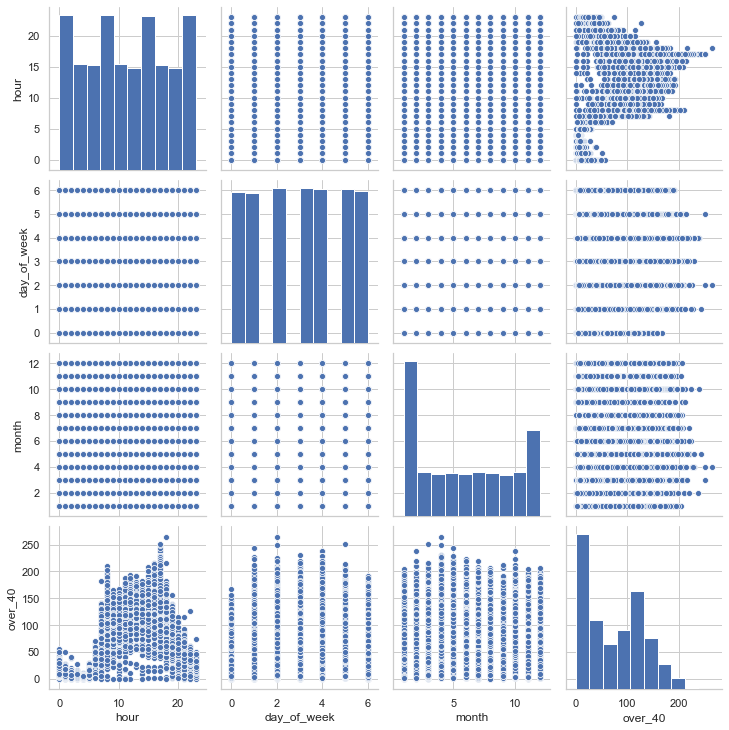

In [66]:
# Scatter plot matrix for the training set

sns.pairplot(train_set)

In [67]:
# Write the training and test sets to csv files so that they can be used in the Notebook 2 for model training

train_set.to_csv('data_wysp/train_set.csv')
test_set.to_csv('data_wysp/test_set.csv')

### Please see the notebook wysp_sign627_notebook2_models.ipynb (it contains further data transformation and models)